In [15]:
"""
    TODO
    1. 명칭 및 구조 통일화
    2. 그래프 및 그림 추가
    3. 피처 추가
"""

'\n    TODO\n    1. 명칭 및 구조 통일화\n    2. 그래프 및 그림 추가\n    3. 피처 추가\n'

In [16]:
# pip install optuna
# pip install optuna-integration

In [17]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

import torch
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import TimeSeriesSplit
import xgboost as xgb
from xgboost.callback import EvaluationMonitor
import optuna
import matplotlib.pyplot as plt

In [18]:
try:
    CUDA = torch.cuda.is_available()
except:
    CUDA = False

print(f"CUDA available: {CUDA}")

CUDA available: False


In [19]:
# -----------------------------
# 1) 경로 설정
# -----------------------------
TRAIN_FP = Path('../open/train/train.csv')
TEST_DIR = Path('../open/test')
SAMPLE_FP = Path('../open/sample_submission.csv')

if not TRAIN_FP.exists() or not TEST_DIR.exists() or not SAMPLE_FP.exists():
    print("Path error: directory or file does not exist. Please check the paths.")
    print(f"Expected file path: {TRAIN_FP}")
    exit()
else:
    print("File paths are valid.")

File paths are valid.


In [20]:
# -----------------------------
# 2) 데이터 로드 및 전처리
# -----------------------------
print("Data loading and preprocessing...")

train = pd.read_csv(TRAIN_FP)
train["영업일자"] = pd.to_datetime(train["영업일자"])

print("Outlier handling using IQR...")

# 분포 비교를 위해 사본 보관
train_raw = train.copy()

# 이상치 처리 함수
def handle_outliers_iqr(df_group):
    non_zero_sales = df_group[df_group["매출수량"] > 0]["매출수량"]
    if len(non_zero_sales) < 5:
        return df_group

    q1, q3 = non_zero_sales.quantile(0.25), non_zero_sales.quantile(0.75)
    iqr = q3 - q1

    # 이상치 기준
    lower_bound = max(0, q1 - 1.5 * iqr)
    upper_bound = q3 + 1.5 * iqr

    df_group["매출수량"] = np.clip(df_group["매출수량"], lower_bound, upper_bound)
    return df_group

train = train.groupby("영업장명_메뉴명", group_keys=False).apply(handle_outliers_iqr)

print("Outlier handling complete")

tests = {}
for i in range(10):
    name = f"TEST_{i:02d}"
    df = pd.read_csv(TEST_DIR / f"{name}.csv")
    df["영업일자"] = pd.to_datetime(df["영업일자"])
    tests[name] = df
    print(f"[{name}] shape: {df.shape} | 날짜: {df['영업일자'].min().date()} ~ {df['영업일자'].max().date()}")

Data loading and preprocessing...
Outlier handling using IQR...
Outlier handling complete
[TEST_00] shape: (5404, 3) | 날짜: 2024-06-16 ~ 2024-07-13
[TEST_01] shape: (5404, 3) | 날짜: 2024-07-21 ~ 2024-08-17
[TEST_02] shape: (5404, 3) | 날짜: 2024-08-25 ~ 2024-09-21
[TEST_03] shape: (5404, 3) | 날짜: 2024-09-29 ~ 2024-10-26
[TEST_04] shape: (5404, 3) | 날짜: 2024-11-03 ~ 2024-11-30
[TEST_05] shape: (5404, 3) | 날짜: 2024-12-08 ~ 2025-01-04
[TEST_06] shape: (5404, 3) | 날짜: 2025-01-12 ~ 2025-02-08
[TEST_07] shape: (5404, 3) | 날짜: 2025-02-16 ~ 2025-03-15
[TEST_08] shape: (5404, 3) | 날짜: 2025-03-23 ~ 2025-04-19
[TEST_09] shape: (5404, 3) | 날짜: 2025-04-27 ~ 2025-05-24


[train] shape: (102676, 3)
[train] 영업일자 범위: 2023-01-01 ~ 2024-06-15
[train] 고유 메뉴 수: 193
[train] 전체 매출수량 합계: 1,064,458.25
[train] 0 매출수량 건수: 50,277 / 102,676 (49.0%)
[IQR] 이상치 클리핑된 행 수: 5,634 (5.49%)
[매출수량] 처리 전 요약:
 count    102676.000000
mean         10.653083
std          41.887692
min         -80.000000
25%           0.000000
50%           0.000000
75%           4.000000
max        1372.000000
[매출수량] 처리 후 요약:
 count    102676.000000
mean         10.367157
std          39.374188
min           0.000000
25%           0.000000
50%           1.000000
75%           4.000000
max        1048.125000
[sample_submission] shape: (70, 194)


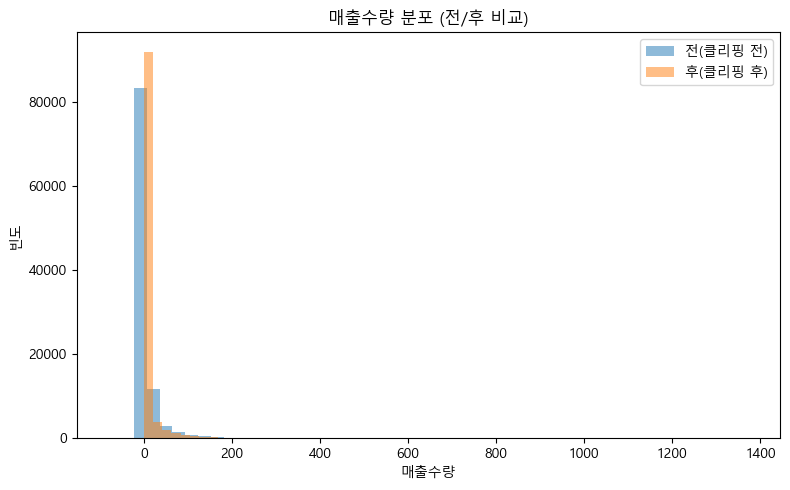

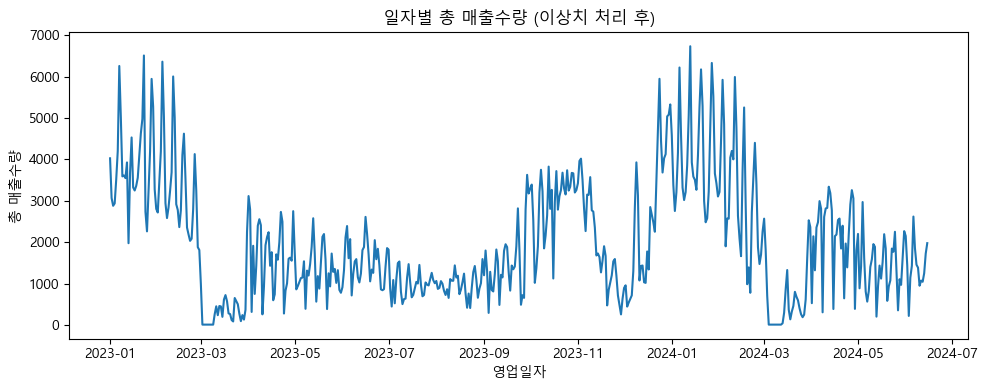

C:\Users\syyun\AppData\Local\Temp\ipykernel_10660\1998658927.py:55: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_to_plot, labels=box_df["영업장명_메뉴명"].cat.categories, showfliers=False)


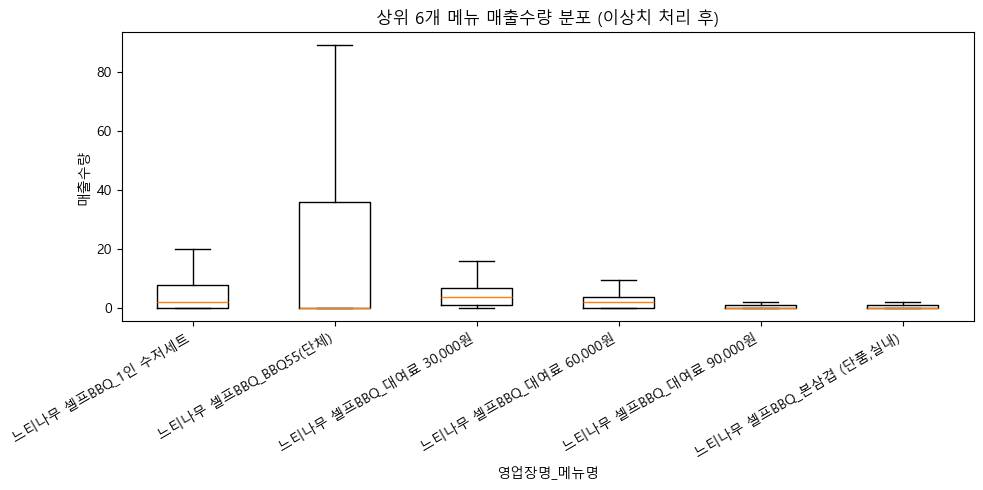

In [21]:
# -----------------------------
# 2-2) 데이터 전처리 출력 및 시각화
# -----------------------------
print(f"[train] shape: {train.shape}")
print(f"[train] 영업일자 범위: {train['영업일자'].min().date()} ~ {train['영업일자'].max().date()}")
print(f"[train] 고유 메뉴 수: {train['영업장명_메뉴명'].nunique():,}")
print(f"[train] 전체 매출수량 합계: {train['매출수량'].sum():,}")
print(f"[train] 0 매출수량 건수: {(train['매출수량'] == 0).sum():,} / "
      f"{len(train):,} ({(train['매출수량'] == 0).mean():.1%})")

diff_cnt = (train["매출수량"] != train_raw["매출수량"]).sum()
print(f"[IQR] 이상치 클리핑된 행 수: {diff_cnt:,} ({diff_cnt/len(train):.2%})")
print("[매출수량] 처리 전 요약:\n", train_raw["매출수량"].describe().to_string())
print("[매출수량] 처리 후 요약:\n", train["매출수량"].describe().to_string())

sample = pd.read_csv(SAMPLE_FP)
print(f"[sample_submission] shape: {sample.shape}")

try:
    plt.rcParams["font.family"] = "Malgun Gothic"
    plt.rcParams["axes.unicode_minus"] = False
except Exception:
    pass

# 매출수량 분포: 처리 전 vs 처리 후
plt.figure(figsize=(8, 5))
bins = 50
plt.hist(train_raw["매출수량"], bins=bins, alpha=0.5, label="전(클리핑 전)")
plt.hist(train["매출수량"], bins=bins, alpha=0.5, label="후(클리핑 후)")
plt.title("매출수량 분포 (전/후 비교)")
plt.xlabel("매출수량")
plt.ylabel("빈도")
plt.legend()
plt.tight_layout()
plt.show()

# 일자별 총 매출수량 시계열(처리 후)
daily_after = train.groupby("영업일자", as_index=False)["매출수량"].sum()
plt.figure(figsize=(10, 4))
plt.plot(daily_after["영업일자"], daily_after["매출수량"])
plt.title("일자별 총 매출수량 (이상치 처리 후)")
plt.xlabel("영업일자")
plt.ylabel("총 매출수량")
plt.tight_layout()
plt.show()

# 상위 6개 메뉴 박스플롯 (처리 후)
top6 = train["영업장명_메뉴명"].value_counts().head(6).index
box_df = train[train["영업장명_메뉴명"].isin(top6)].copy()
# 카테고리 순서 유지 위해 카테고리형으로 변환
box_df["영업장명_메뉴명"] = box_df["영업장명_메뉴명"].astype("category")
plt.figure(figsize=(10, 5))
# Matplotlib 기본 boxplot 사용
data_to_plot = [box_df.loc[box_df["영업장명_메뉴명"] == k, "매출수량"] for k in box_df["영업장명_메뉴명"].cat.categories]
plt.boxplot(data_to_plot, labels=box_df["영업장명_메뉴명"].cat.categories, showfliers=False)
plt.title("상위 6개 메뉴 매출수량 분포 (이상치 처리 후)")
plt.xlabel("영업장명_메뉴명")
plt.ylabel("매출수량")
plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.show()

In [22]:
# -----------------------------
# 3) 피처 엔지니어링
# -----------------------------
print("Feature engineering...")

encoder = LabelEncoder()
train["item_id"] = encoder.fit_transform(train["영업장명_메뉴명"])

# 영업일자에서 날짜 관련 피처 생성
def make_date_feats(df):
    out = df.copy()
    out["year"], out["month"], out["day"], out["weekday"] = (
        out["영업일자"].dt.year,
        out["영업일자"].dt.month,
        out["영업일자"].dt.day,
        out["영업일자"].dt.weekday,
    )
    out["is_weekend"] = (
        out["weekday"].isin([5, 6]).astype(int)
    )

    # 주기적 특성 변환
    out["month_sin"], out["month_cos"] = np.sin(
        2 * np.pi * out["month"] / 12.0
    ), np.cos(2 * np.pi * out["month"] / 12.0)
    out["wday_sin"], out["wday_cos"] = np.sin(2 * np.pi * out["weekday"] / 7.0), np.cos(
        2 * np.pi * out["weekday"] / 7.0
    )
    return out

# 영업일자 피처 생성 및 정렬
train = make_date_feats(train)
train = train.sort_values(["item_id", "영업일자"])

for lag in [1, 7, 14, 28]:
    train[f"lag_{lag}"] = train.groupby("item_id")["매출수량"].shift(lag)

g = train.groupby("item_id")["매출수량"]
train["roll_mean_7"], train["roll_mean_14"], train["roll_std_7"] = (
    g.shift(1).rolling(7).mean(),
    g.shift(1).rolling(14).mean(),
    g.shift(1).rolling(7).std(),
)

train = train.dropna()
print("Feature engineering complete")

feature_cols = [
    "year",
    "month",
    "day",
    "weekday",
    "is_weekend",
    "month_sin",
    "month_cos",
    "wday_sin",
    "wday_cos",
    "item_id",
    "lag_1",
    "lag_7",
    "lag_14",
    "lag_28",
    "roll_mean_7",
    "roll_mean_14",
    "roll_std_7",
]

train['weight'] = 1.0

# '담하' 또는 '미라시아'가 포함된 경우 가중치를 2.0으로 상향 (값은 실험을 통해 조절 가능)
train.loc[train['영업장명_메뉴명'].str.contains('담하|미라시아'), 'weight'] = 2.0

print(train['weight'].value_counts())
X, y, weights = train[feature_cols], train["매출수량"].astype(float), train["weight"]

Feature engineering...
Feature engineering complete
weight
1.0    60480
2.0    36792
Name: count, dtype: int64


C:\Users\syyun\AppData\Local\Temp\ipykernel_10660\1616908626.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['weight'] = 1.0



[Feature Matrix / Target 요약]
X shape: (97272, 17) | y length: 97272
사용 피처(17): ['year', 'month', 'day', 'weekday', 'is_weekend', 'month_sin', 'month_cos', 'wday_sin', 'wday_cos', 'item_id', 'lag_1', 'lag_7', 'lag_14', 'lag_28', 'roll_mean_7', 'roll_mean_14', 'roll_std_7']
결측치: 없음

[Target(매출수량) 통계]
count    97272.000000
mean         9.824136
std         37.663119
min          0.000000
25%          0.000000
50%          1.000000
75%          4.000000
max       1048.125000

[요일별 매출 요약]
                평균  중앙값     건수
weekday                       
0         6.826146  0.0  13896
1         7.960843  0.0  13896
2         7.579483  0.0  13896
3         9.328323  0.0  13896
4        11.652832  1.0  13896
5        13.574068  2.0  13896
6        11.847258  1.0  13896

[상위 5개 item_id (총 매출수량 기준)]
item_id
187    60126.000
168    52801.875
169    45094.500
171    32440.250
147    25851.000

[매출수량과의 상관계수 TOP 8]
roll_mean_7     0.822644
lag_1           0.802757
roll_mean_14    0.799898
lag_7        

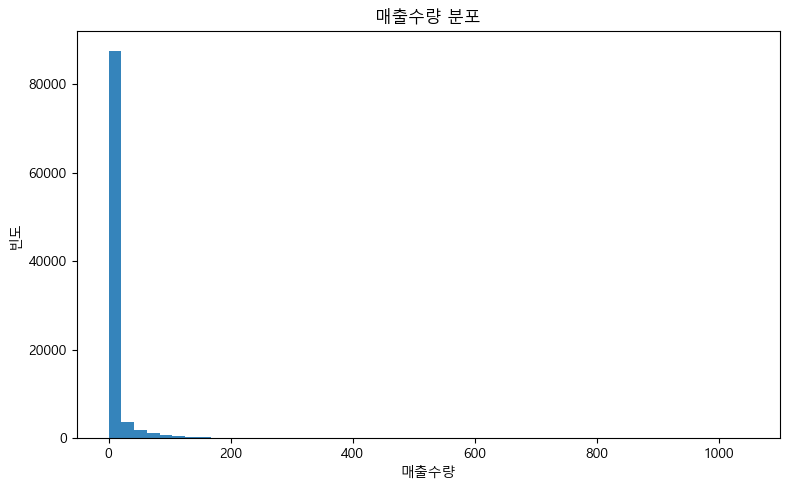

C:\Users\syyun\AppData\Local\Temp\ipykernel_10660\1684723580.py:54: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_box, labels=[0,1,2,3,4,5,6], showfliers=False)


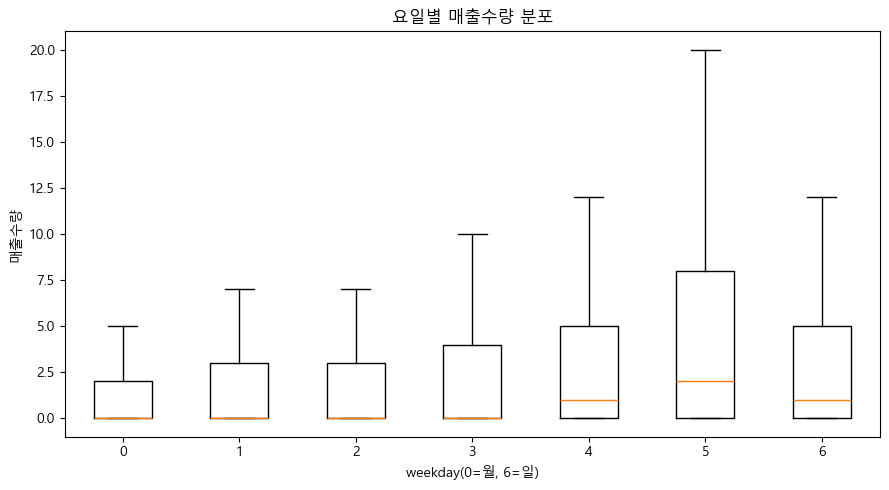

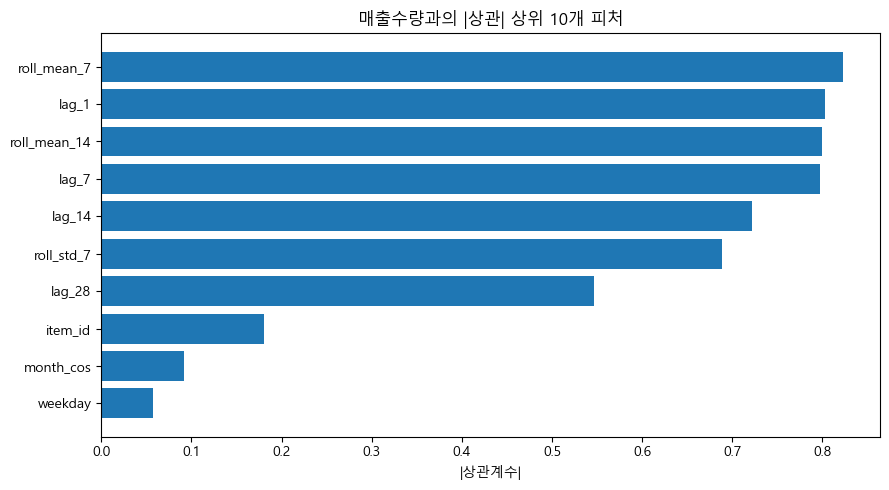

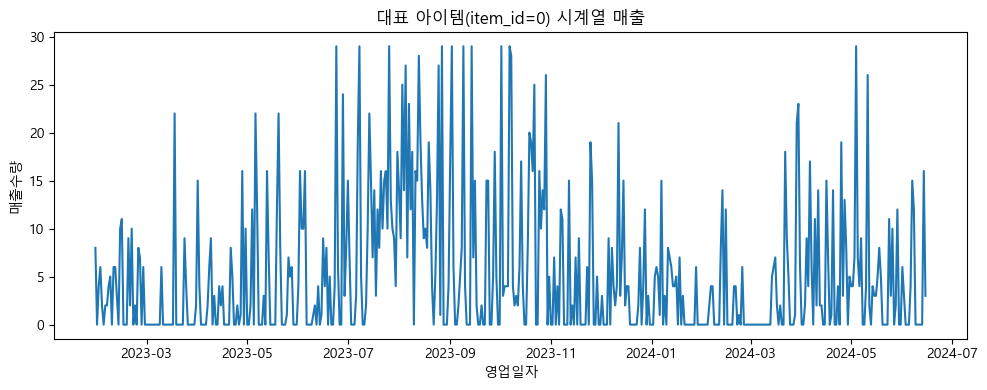

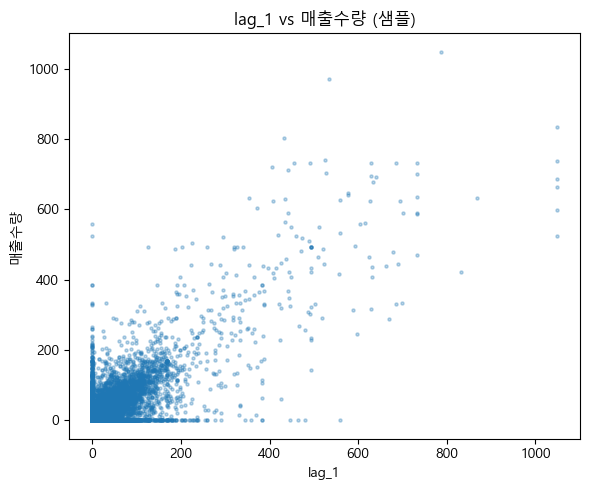

In [23]:
# -----------------------------
# 3-2) 피처 출력 및 시각화
# -----------------------------
print("\n[Feature Matrix / Target 요약]")
print(f"X shape: {X.shape} | y length: {len(y)}")
print(f"사용 피처({len(feature_cols)}): {feature_cols}")

nulls = X.isna().sum()
if nulls.sum() == 0:
    print("결측치: 없음")
else:
    print("결측치 컬럼 및 개수:\n", nulls[nulls > 0].sort_values(ascending=False).to_string())

print("\n[Target(매출수량) 통계]")
print(train["매출수량"].describe().to_string())

print("\n[요일별 매출 요약]")
wday_stats = train.groupby("weekday")["매출수량"].agg(["mean","median","count"]).rename(columns={
    "mean":"평균","median":"중앙값","count":"건수"
})
print(wday_stats.to_string())

print("\n[상위 5개 item_id (총 매출수량 기준)]")
top_items = train.groupby("item_id")["매출수량"].sum().sort_values(ascending=False).head(5)
print(top_items.to_string())

# 상관계수(단순 피어슨) 상위/하위 피처
corr_s = pd.concat([X, y.rename("매출수량")], axis=1).corr(numeric_only=True)["매출수량"].drop(labels=["매출수량"])
corr_top = corr_s.sort_values(ascending=False).head(8)
corr_bot = corr_s.sort_values(ascending=True).head(8)
print("\n[매출수량과의 상관계수 TOP 8]")
print(corr_top.to_string())
print("\n[매출수량과의 상관계수 BOTTOM 8]")
print(corr_bot.to_string())

# 한글 폰트(가능하면) 설정
try:
    plt.rcParams["font.family"] = "Malgun Gothic"  # Windows
    plt.rcParams["axes.unicode_minus"] = False
except Exception:
    pass

# 매출수량 분포 히스토그램
plt.figure(figsize=(8,5))
plt.hist(train["매출수량"], bins=50, alpha=0.9)
plt.title("매출수량 분포")
plt.xlabel("매출수량"); plt.ylabel("빈도")
plt.tight_layout()
plt.show()

# 요일별 박스플롯 (주말 효과 등 확인)
plt.figure(figsize=(9,5))
data_box = [train.loc[train["weekday"] == d, "매출수량"] for d in range(7)]
plt.boxplot(data_box, labels=[0,1,2,3,4,5,6], showfliers=False)
plt.title("요일별 매출수량 분포")
plt.xlabel("weekday(0=월, 6=일)"); plt.ylabel("매출수량")
plt.tight_layout()
plt.show()

# 상관계수 상위 10개 막대 그래프(절댓값 기준)
plt.figure(figsize=(9,5))
top_abs = corr_s.abs().sort_values(ascending=False).head(10)
plt.barh(top_abs.index[::-1], top_abs.values[::-1])
plt.title("매출수량과의 |상관| 상위 10개 피처")
plt.xlabel("|상관계수|")
plt.tight_layout()
plt.show()

# 대표 아이템 1개 시계열 추이
top_item_id = train["item_id"].value_counts().idxmax()
one = train[train["item_id"] == top_item_id].sort_values("영업일자")
plt.figure(figsize=(10,4))
plt.plot(one["영업일자"], one["매출수량"])
plt.title(f"대표 아이템(item_id={top_item_id}) 시계열 매출")
plt.xlabel("영업일자"); plt.ylabel("매출수량")
plt.tight_layout()
plt.show()

# lag_1 vs 매출수량 산점도 (샘플링)
plt.figure(figsize=(6,5))
plot_sample = train.dropna(subset=["lag_1"]).sample(n=min(50000, len(train)), random_state=42)
plt.scatter(plot_sample["lag_1"], plot_sample["매출수량"], s=5, alpha=0.3)
plt.title("lag_1 vs 매출수량 (샘플)")
plt.xlabel("lag_1"); plt.ylabel("매출수량")
plt.tight_layout()
plt.show()

In [24]:
# -----------------------------
# 4) Optuna를 이용한 하이퍼파라미터 튜닝
# -----------------------------
print("Optuna hyperparameter tuning...")

tscv = TimeSeriesSplit(n_splits=5)

def objective(trial):
    params = {
        "objective": "reg:squarederror",
        "eval_metric": "rmse",
        "tree_method": "hist",
        "device": "cuda" if CUDA else "cpu",
        "seed": 42,
        "max_depth": trial.suggest_int("max_depth", 4, 12),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "gamma": trial.suggest_float("gamma", 1e-8, 1.0, log=True),
        "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
        "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
    }
    rmses = []
    for tr_idx, va_idx in tscv.split(X):
        X_tr, X_va = X.iloc[tr_idx], X.iloc[va_idx]
        y_tr, y_va = y.iloc[tr_idx], y.iloc[va_idx]
        w_tr, w_va = weights.iloc[tr_idx], weights.iloc[va_idx]
        dtr, dva = xgb.DMatrix(X_tr, label=y_tr, weight=w_tr), xgb.DMatrix(X_va, label=y_va, weight=w_va)

        pruning_callback = optuna.integration.XGBoostPruningCallback(trial, "val-rmse")
        trained_model = xgb.train(
            params,
            dtr,
            num_boost_round=1000,
            evals=[(dva, "val")],
            early_stopping_rounds=50,
            callbacks=[pruning_callback],
            verbose_eval=False,
        )
        rmses.append(trained_model.best_score)

    return np.mean(rmses)

warnings.filterwarnings(
    "ignore",
    category=UserWarning,
    message=r"The reported value is ignored because this `step` \d+ is already reported\."
)

study = optuna.create_study(
    direction="minimize", pruner=optuna.pruners.MedianPruner(n_warmup_steps=5)
)
study.optimize(
    objective, n_trials=50
)

print(f"Best hyperparameter: {study.best_params}")
print(f"Best RMSE: {study.best_value}")

[I 2025-08-15 17:48:49,758] A new study created in memory with name: no-name-a288eba9-5f0a-4b3b-88d2-2059216338d9


Optuna hyperparameter tuning...


[I 2025-08-15 17:48:51,146] Trial 0 finished with value: 20.19116499978177 and parameters: {'max_depth': 4, 'learning_rate': 0.2223024694091852, 'subsample': 0.8815821243178443, 'colsample_bytree': 0.775833874281856, 'gamma': 7.988968070412667e-05, 'lambda': 4.907698512064196e-05, 'alpha': 3.4583675653478537e-05}. Best is trial 0 with value: 20.19116499978177.
[I 2025-08-15 17:48:53,011] Trial 1 finished with value: 20.161885467492954 and parameters: {'max_depth': 4, 'learning_rate': 0.1774250570931272, 'subsample': 0.7937328976307833, 'colsample_bytree': 0.7866536208344882, 'gamma': 2.3965068178777726e-05, 'lambda': 0.08642740239330512, 'alpha': 0.3396854555743361}. Best is trial 1 with value: 20.161885467492954.
[I 2025-08-15 17:48:57,292] Trial 2 finished with value: 22.44208057557111 and parameters: {'max_depth': 10, 'learning_rate': 0.2509767700860786, 'subsample': 0.9335231125376235, 'colsample_bytree': 0.7785482283208401, 'gamma': 0.030522913272787798, 'lambda': 1.26893383259824

Best hyperparameter: {'max_depth': 4, 'learning_rate': 0.1441448733217767, 'subsample': 0.6449659049177776, 'colsample_bytree': 0.8919430314435346, 'gamma': 0.0005141480181278911, 'lambda': 0.0003796668456844216, 'alpha': 0.0017942763337585356}
Best RMSE: 19.53027898836536


Model training with best hyperparameters...
[0]	val-rmse:77.13399
[10]	val-rmse:55.90506
[20]	val-rmse:50.40583
[30]	val-rmse:52.29165
[40]	val-rmse:54.55840
[50]	val-rmse:57.77857
[60]	val-rmse:58.52298
[70]	val-rmse:62.12748
[80]	val-rmse:65.65581
[90]	val-rmse:64.60071
[100]	val-rmse:64.23884
[110]	val-rmse:65.81512
[120]	val-rmse:66.26740
[123]	val-rmse:66.40002
Best iteration: 24


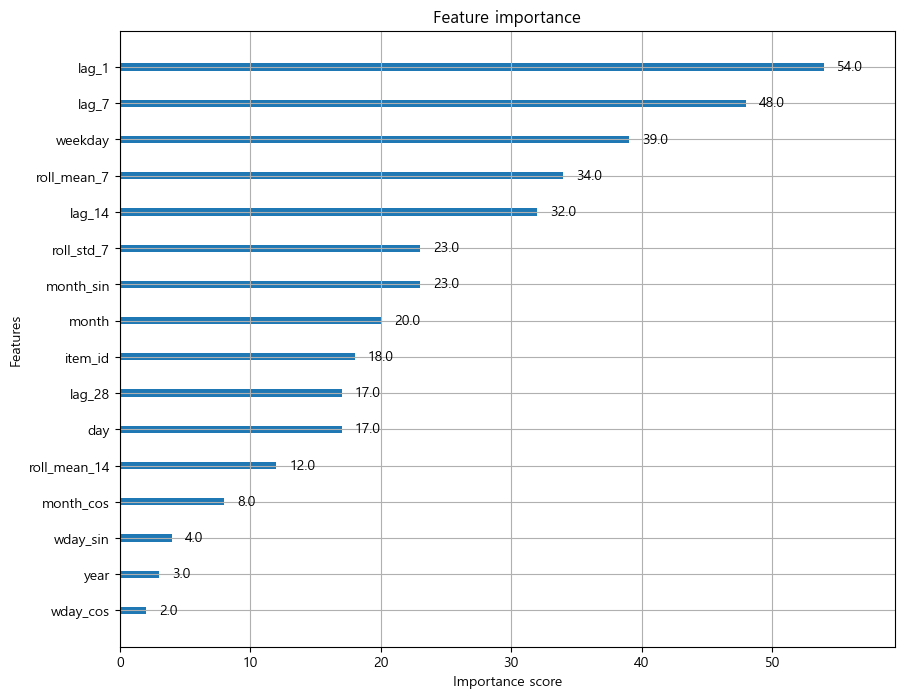

In [25]:
# -----------------------------
# 5) 최적 파라미터로 모델 학습
# -----------------------------
print("Model training with best hyperparameters...")

best_params = study.best_params
best_params.update(
    {
        "objective": "reg:squarederror",
        "eval_metric": "rmse",
        "tree_method": "hist",
        "device": "cuda" if CUDA else "cpu",
    }
)

# 최적 파라미터로 마지막 fold 학습
last_tr_idx, last_va_idx = list(tscv.split(X))[-1]
X_tr, X_va = X.iloc[last_tr_idx], X.iloc[last_va_idx]
y_tr, y_va = y.iloc[last_tr_idx], y.iloc[last_va_idx]
dtr, dva = xgb.DMatrix(X_tr, label=y_tr), xgb.DMatrix(X_va, label=y_va)
trained_model = xgb.train(
    best_params,
    dtr,
    num_boost_round=5000,
    evals=[(dva, "val")],
    early_stopping_rounds=100,
    verbose_eval=False,
    callbacks=[EvaluationMonitor(period=10)]
)
final_boost_round = trained_model.best_iteration

data_dmatrix = xgb.DMatrix(X, label=y, weight=weights)
final_model = xgb.train(
    best_params, 
    data_dmatrix, 
    num_boost_round=final_boost_round, 
    verbose_eval=False
)

print(f"Best iteration: {final_boost_round}")

fig, ax = plt.subplots(figsize=(10, 8))
xgb.plot_importance(final_model, ax=ax)
plt.show()

In [26]:
# -----------------------------
# 6) 재귀 예측
# -----------------------------
print("Recursive prediction...")
all_preds = []
full_history = train.copy()

# 중간 로그 누적용
step_logs = []

for test_name, test_df in tests.items():
    test_df = test_df.copy()
    test_df["item_id"] = encoder.transform(test_df["영업장명_메뉴명"])
    test_df = make_date_feats(test_df)

    # 학습 데이터와 테스트 데이터 병합
    history = pd.concat([full_history, test_df], ignore_index=True)
    history = history.sort_values(["item_id", "영업일자"])

    last_date = test_df["영업일자"].max()
    items = test_df["영업장명_메뉴명"].unique()

    preds_rows = []
    current_date = last_date
    for step in range(1, 8):
        target_date = current_date + pd.Timedelta(days=1)

        # 예측을 위한 데이터 프레임 생성
        frame = pd.DataFrame(
            {"영업일자": np.repeat(target_date, len(items)), "영업장명_메뉴명": items}
        )
        frame["item_id"] = encoder.transform(frame["영업장명_메뉴명"])
        frame = make_date_feats(frame)

        # 특징 계산
        temp_hist = history.copy()
        for lag in [1, 7, 14, 28]:
            lagged = temp_hist[["영업일자", "item_id", "매출수량"]].copy()
            lagged["영업일자"] = lagged["영업일자"] + pd.Timedelta(days=lag)
            frame = frame.merge(
                lagged.rename(columns={"매출수량": f"lag_{lag}"}),
                on=["영업일자", "item_id"],
                how="left",
            )

        roll_base = temp_hist.sort_values(["item_id", "영업일자"]).copy()
        gb = roll_base.groupby("item_id")["매출수량"]
        roll_base["roll_mean_7"] = gb.rolling(7).mean().reset_index(0, drop=True)
        roll_base["roll_mean_14"] = gb.rolling(14).mean().reset_index(0, drop=True)
        roll_base["roll_std_7"] = gb.rolling(7).std().reset_index(0, drop=True)
        roll_base["영업일자"] = roll_base["영업일자"] + pd.Timedelta(days=1)
        frame = frame.merge(
            roll_base[
                ["영업일자", "item_id", "roll_mean_7", "roll_mean_14", "roll_std_7"]
            ],
            on=["영업일자", "item_id"],
            how="left",
        )

        # 결측치 채우기 전/후 카운트 집계
        nan_before = int(frame[feature_cols].isna().sum().sum())
        frame[feature_cols] = frame[feature_cols].fillna(0)
        nan_after = int(frame[feature_cols].isna().sum().sum())
        # frame[feature_cols] = frame[feature_cols].fillna(0)

        # 예측 수행
        X_pred = frame[feature_cols]
        dpred = xgb.DMatrix(X_pred)
        yhat = final_model.predict(dpred)
        yhat = np.clip(yhat, 0, None)
        frame["pred"] = yhat

        # step별 요약 프린트 & 로그 저장
        pred_sum = float(yhat.sum())
        pred_mean = float(yhat.mean())
        pred_std = float(yhat.std() if len(yhat) else 0.0)
        print(
            f"[{test_name}] step {step} | date={target_date.date()} | "
            f"rows={len(frame):,} | NaN(before→after)={nan_before}->{nan_after} | "
            f"pred_sum={pred_sum:,.2f} | pred_mean={pred_mean:.3f} | pred_std={pred_std:.3f}"
        )
        step_logs.append({
            "test": test_name,
            "step": step,
            "target_date": target_date,
            "rows": int(len(frame)),
            "nan_before": nan_before,
            "nan_after": nan_after,
            "pred_sum": pred_sum,
            "pred_mean": pred_mean,
            "pred_std": pred_std,
        })

        # 이전 예측 결과를 history에 추가해 재귀
        add_hist = frame[["영업일자", "item_id", "영업장명_메뉴명", "pred"]].rename(
            columns={"pred": "매출수량"}
        )
        history = pd.concat([history, add_hist], ignore_index=True)

        # 결과 저장
        frame_out = frame[["영업일자", "영업장명_메뉴명", "pred"]].copy()
        frame_out["영업일자"] = f"{test_name}+{step}일"
        preds_rows.append(frame_out)

        current_date = target_date

    test_pred = pd.concat(preds_rows, ignore_index=True)
    wide = test_pred.pivot(index="영업일자", columns="영업장명_메뉴명", values="pred")
    all_preds.append(wide)

print("Prediction complete")

Recursive prediction...
[TEST_00] step 1 | date=2024-07-14 | rows=193 | NaN(before→after)=0->0 | pred_sum=1,189.34 | pred_mean=6.162 | pred_std=15.095
[TEST_00] step 2 | date=2024-07-15 | rows=193 | NaN(before→after)=0->0 | pred_sum=698.19 | pred_mean=3.618 | pred_std=5.882
[TEST_00] step 3 | date=2024-07-16 | rows=193 | NaN(before→after)=0->0 | pred_sum=780.25 | pred_mean=4.043 | pred_std=7.990
[TEST_00] step 4 | date=2024-07-17 | rows=193 | NaN(before→after)=0->0 | pred_sum=726.04 | pred_mean=3.762 | pred_std=6.451
[TEST_00] step 5 | date=2024-07-18 | rows=193 | NaN(before→after)=0->0 | pred_sum=863.91 | pred_mean=4.476 | pred_std=8.438
[TEST_00] step 6 | date=2024-07-19 | rows=193 | NaN(before→after)=0->0 | pred_sum=1,053.70 | pred_mean=5.460 | pred_std=11.624
[TEST_00] step 7 | date=2024-07-20 | rows=193 | NaN(before→after)=0->0 | pred_sum=1,237.39 | pred_mean=6.411 | pred_std=11.227
[TEST_01] step 1 | date=2024-08-18 | rows=193 | NaN(before→after)=0->0 | pred_sum=950.84 | pred_mea


[재귀 예측 요약표 (각 테스트의 step별 집계)]
              rows  nan_before  nan_after     pred_sum  pred_mean   pred_std
test    step                                                                
TEST_00 1      193           0          0  1189.344971   6.162409  15.094532
        2      193           0          0   698.193909   3.617585   5.882023
        3      193           0          0   780.252686   4.042760   7.989926
        4      193           0          0   726.038879   3.761859   6.450617
        5      193           0          0   863.906494   4.476200   8.438386
        6      193           0          0  1053.697754   5.459574  11.624042
        7      193           0          0  1237.385620   6.411325  11.227149
TEST_01 1      193           0          0   950.841736   4.926641   9.975299
        2      193           0          0   702.730347   3.641090   5.131856
        3      193           0          0   690.604736   3.578263   5.060110
        4      193           0          0   6

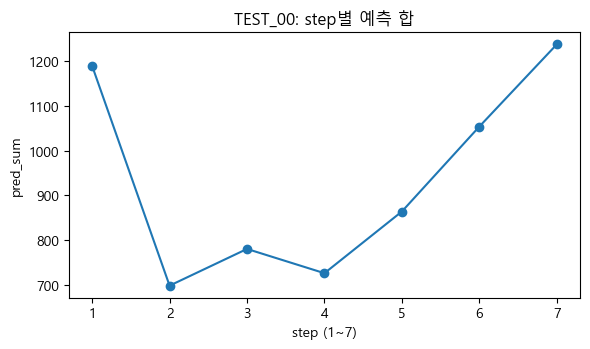

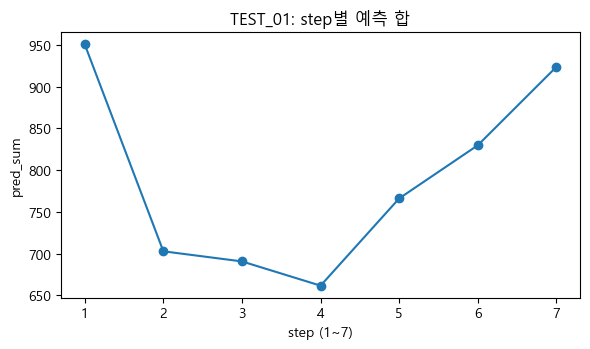

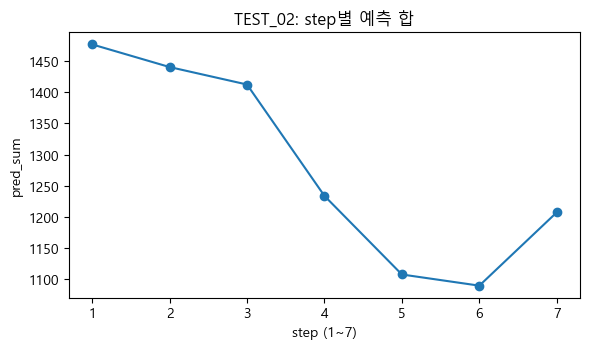

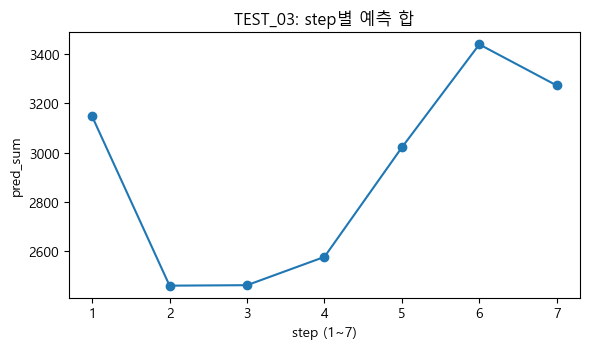

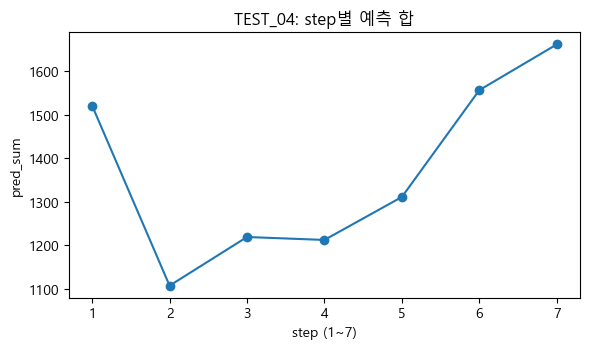

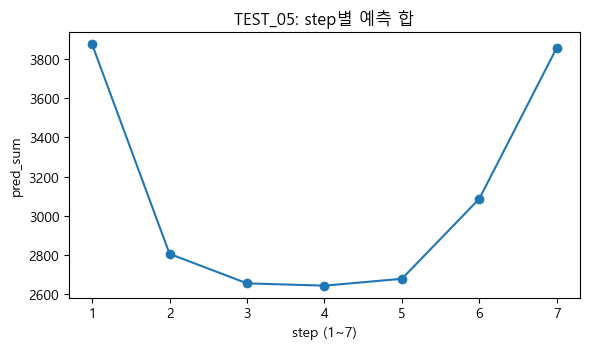

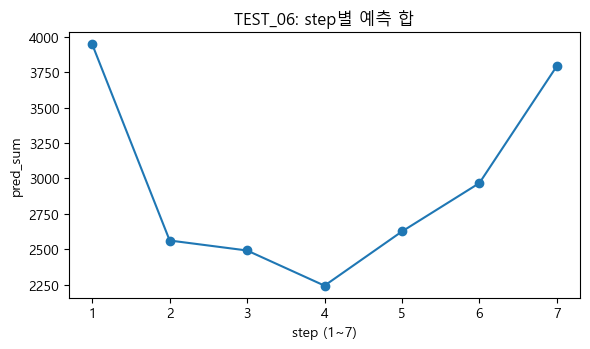

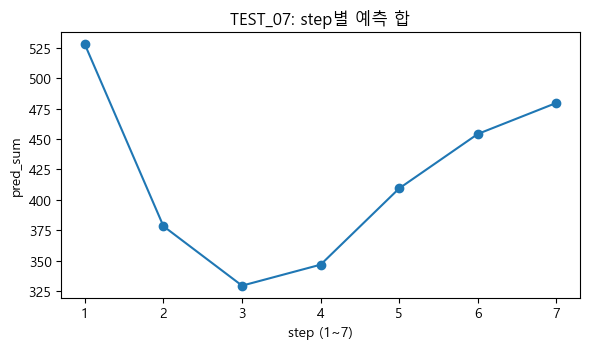

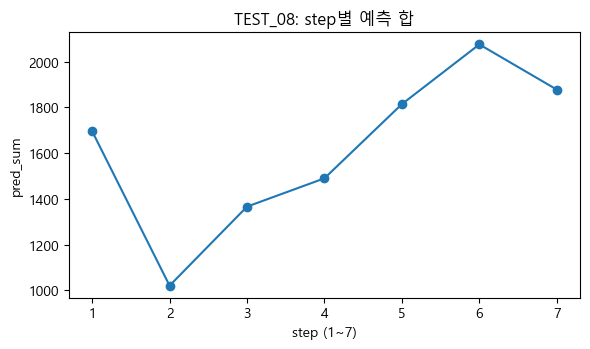

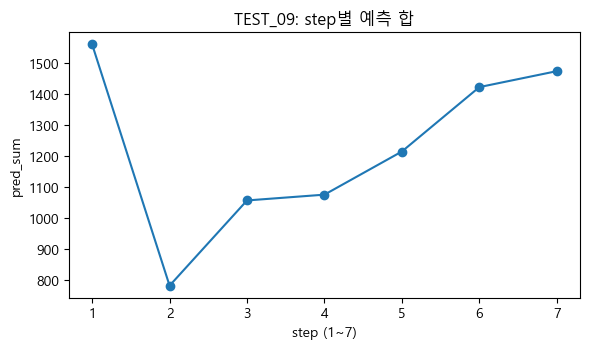

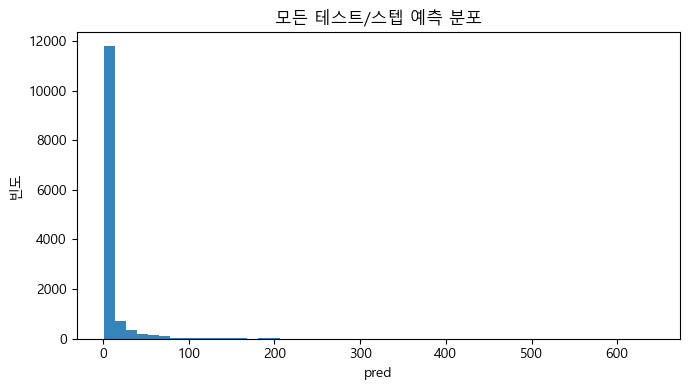

In [27]:
# -----------------------------
# 6-2) 예측 분포 출력
# -----------------------------
try:
    plt.rcParams["font.family"] = "Malgun Gothic"  # 한글 폰트(Windows)
    plt.rcParams["axes.unicode_minus"] = False
except Exception:
    pass

# 표 형태 요약 출력
if step_logs:
    import pandas as pd
    log_df = pd.DataFrame(step_logs)
    print("\n[재귀 예측 요약표 (각 테스트의 step별 집계)]")
    summary = (log_df.groupby(["test", "step"])
               .agg(rows=("rows", "sum"),
                    nan_before=("nan_before", "sum"),
                    nan_after=("nan_after", "sum"),
                    pred_sum=("pred_sum", "sum"),
                    pred_mean=("pred_mean", "mean"),
                    pred_std=("pred_std", "mean"))
               )
    print(summary.to_string())

    # 테스트별 step-예측합 라인차트
    for tname, g in log_df.groupby("test"):
        g = g.sort_values("step")
        plt.figure(figsize=(6, 3.6))
        plt.plot(g["step"], g["pred_sum"], marker="o")
        plt.title(f"{tname}: step별 예측 합")
        plt.xlabel("step (1~7)")
        plt.ylabel("pred_sum")
        plt.xticks(range(1, 8))
        plt.tight_layout()
        plt.show()

    # 전체 예측 분포 히스토그램
    try:
        all_pred_vals = pd.concat(all_preds).values.ravel()
        all_pred_vals = pd.Series(all_pred_vals, dtype=float)
        all_pred_vals = all_pred_vals[~np.isnan(all_pred_vals)]
        plt.figure(figsize=(7, 4))
        plt.hist(all_pred_vals, bins=50, alpha=0.9)
        plt.title("모든 테스트/스텝 예측 분포")
        plt.xlabel("pred")
        plt.ylabel("빈도")
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print("전체 예측 히스토그램 생성 스킵:", e)

In [28]:
# -----------------------------
# 7) 최종 제출 파일 생성
# -----------------------------
submission = pd.concat(all_preds)
submission = submission.reset_index().rename(columns={"index": "영업일자"})
submission = submission[sample.columns]
out_path = '../open/out/submission_xgboost_5.csv'
submission.to_csv(out_path, index=False, encoding="utf-8-sig")

print(f"Submission file created: {out_path}")

Submission file created: ../open/out/submission_xgboost_5.csv
